In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import os
from torchvision.transforms import Normalize, Compose, ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy import signal
from skimage.metrics import structural_similarity as ssim
from IPython.display import clear_output
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize, Compose, ToTensor
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

In [26]:
!pip install names_generator

In [27]:
from names_generator import generate_name

In [28]:
base_path = "/home/diya/Projects/super_resolution/"
working_dir = "/home/diya/Projects/super_resolution/"
input_path = base_path + "dataset/"
output_path = working_dir + "final_outputs/resnet/"

# create directories for checkpoints and logs
log_dir = output_path + "logs/"
checkpoint_dir = output_path + "ckpt/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [29]:
train_df = pd.read_csv(input_path + "train.csv")
val_df = pd.read_csv(input_path + "val.csv")
test_df = pd.read_csv(input_path + "test.csv")

In [30]:
train_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


In [31]:
val_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,6763087613503343044,RHO_kgm-3_id6763087613503343044.dat,UX_ms-1_id6763087613503343044.dat,UY_ms-1_id6763087613503343044.dat,UZ_ms-1_id6763087613503343044.dat
1,7184356030387874174,RHO_kgm-3_id7184356030387874174.dat,UX_ms-1_id7184356030387874174.dat,UY_ms-1_id7184356030387874174.dat,UZ_ms-1_id7184356030387874174.dat
2,7026493720303378708,RHO_kgm-3_id7026493720303378708.dat,UX_ms-1_id7026493720303378708.dat,UY_ms-1_id7026493720303378708.dat,UZ_ms-1_id7026493720303378708.dat
3,5093314759039638268,RHO_kgm-3_id5093314759039638268.dat,UX_ms-1_id5093314759039638268.dat,UY_ms-1_id5093314759039638268.dat,UZ_ms-1_id5093314759039638268.dat
4,-2499630993713878664,RHO_kgm-3_id-2499630993713878664.dat,UX_ms-1_id-2499630993713878664.dat,UY_ms-1_id-2499630993713878664.dat,UZ_ms-1_id-2499630993713878664.dat


In [32]:
test_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-657116647631363807,RHO_kgm-3_id-657116647631363807.dat,UX_ms-1_id-657116647631363807.dat,UY_ms-1_id-657116647631363807.dat,UZ_ms-1_id-657116647631363807.dat
1,7483162365939134796,RHO_kgm-3_id7483162365939134796.dat,UX_ms-1_id7483162365939134796.dat,UY_ms-1_id7483162365939134796.dat,UZ_ms-1_id7483162365939134796.dat
2,-6212758420087317096,RHO_kgm-3_id-6212758420087317096.dat,UX_ms-1_id-6212758420087317096.dat,UY_ms-1_id-6212758420087317096.dat,UZ_ms-1_id-6212758420087317096.dat
3,-1825935182480952214,RHO_kgm-3_id-1825935182480952214.dat,UX_ms-1_id-1825935182480952214.dat,UY_ms-1_id-1825935182480952214.dat,UZ_ms-1_id-1825935182480952214.dat
4,-1859240836295259171,RHO_kgm-3_id-1859240836295259171.dat,UX_ms-1_id-1859240836295259171.dat,UY_ms-1_id-1859240836295259171.dat,UZ_ms-1_id-1859240836295259171.dat


Index:1173


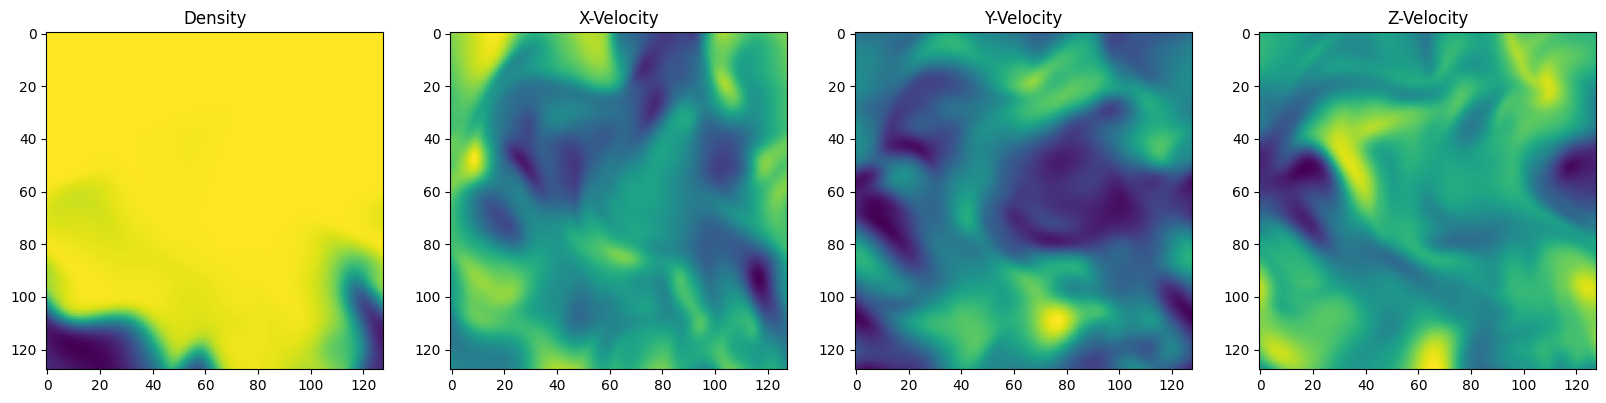

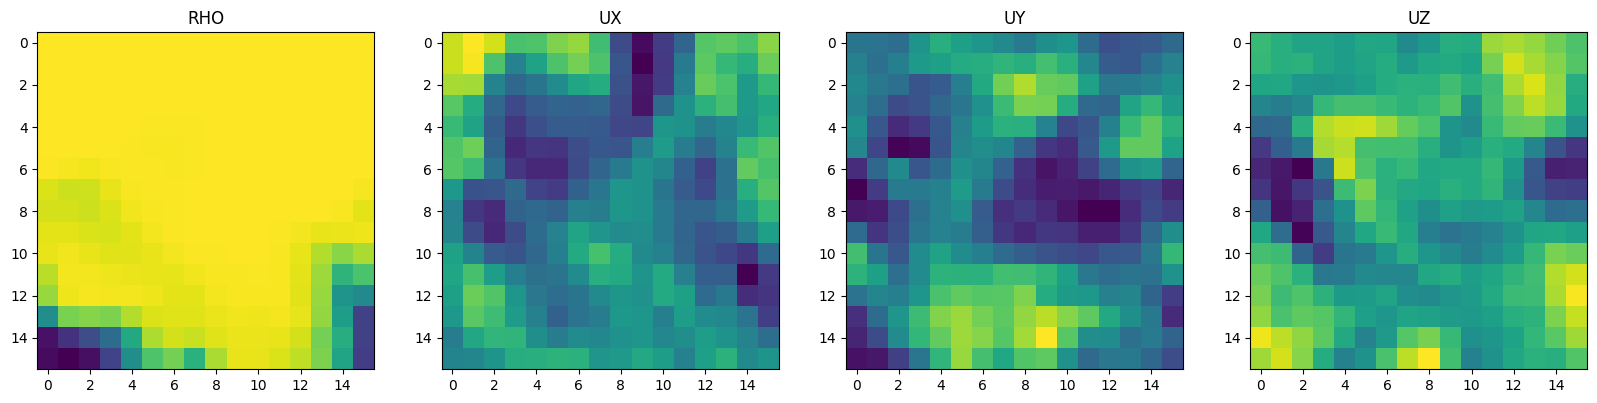

In [33]:
idx = np.random.choice(range(len(train_df)))
print(f"Index:{idx}")
data_path = input_path + "flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='viridis')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='viridis')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='viridis')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='viridis')
axs[3].set_title('Z-Velocity')
plt.show()

HR_X = np.concatenate([RHO.reshape(128, 128, 1), UX.reshape(128, 128, 1),
                       UY.reshape(128, 128, 1), UZ.reshape(128, 128, 1)], axis=-1)

# plot LR features

data_path = input_path + "flowfields/LR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

LR_X = np.concatenate([RHO.reshape(16, 16, 1), UX.reshape(16, 16, 1),
                       UY.reshape(16, 16, 1), UZ.reshape(16, 16, 1)], axis=-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='viridis')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='viridis')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='viridis')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='viridis')
axs[3].set_title('UZ')
plt.show()

In [34]:
class FlowFieldDataset(Dataset):
    def __init__(self, input_path, mode):
        assert mode in ["train", "val", "test"]
        self.mode = mode
        self.csv_file = pd.read_csv(input_path + f"{mode}.csv")
        if mode == "test":
            self.csv_file = pd.read_csv(input_path + f"{mode}.csv")
        self.LR_path = input_path + "flowfields/LR/" + mode
        self.HR_path = input_path + "flowfields/HR/" + mode

        self.mean = np.array([0.24, 28.0, 28.0, 28.0])
        self.std = np.array([0.068, 48.0, 48.0, 48.0])

    def transform(self, x):
        return Compose([ToTensor(), Normalize(self.mean, self.std, inplace=True)])(x)

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # input
        if self.mode == "test":
            id = self.csv_file["id"][idx]
            rho_i = np.fromfile(self.LR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(16, 16)
            ux_i = np.fromfile(self.LR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(16, 16)
            uy_i = np.fromfile(self.LR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(16, 16)
            uz_i = np.fromfile(self.LR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(16, 16)
            X = np.stack([rho_i, ux_i, uy_i, uz_i], axis=2)
            return id, self.transform(X)

        rho_i = np.fromfile(self.LR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(16, 16)
        ux_i = np.fromfile(self.LR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(16, 16)
        uy_i = np.fromfile(self.LR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(16, 16)
        uz_i = np.fromfile(self.LR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(16, 16)
        # output
        rho_o = np.fromfile(self.HR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(128, 128)
        ux_o = np.fromfile(self.HR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(128, 128)
        uy_o = np.fromfile(self.HR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(128, 128)
        uz_o = np.fromfile(self.HR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(128, 128)
        X = np.stack([rho_i, ux_i, uy_i, uz_i], axis=2)
        Y = np.stack([rho_o, ux_o, uy_o, uz_o], axis=2)
        return self.transform(X), self.transform(Y)



In [35]:
num_filters = 64*4
num_of_residual_blocks = 16
batch_size = 256

train_dataset = FlowFieldDataset(input_path=input_path, mode="train")
val_dataset = FlowFieldDataset(input_path=input_path, mode="val")
test_dataset = FlowFieldDataset(input_path=input_path, mode="test")
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, pin_memory=False)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size=3):
        super(ResNetBlock, self).__init__()
        self.resnet_block = torch.nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_filters, num_filters, kernel_size, padding="same")
        )
        self.input = nn.Sequential()

    def forward(self, x):
        inp = self.input(x)
        x = self.resnet_block(x)
        return x + inp

class Model(nn.Module):
    def __init__(
        self, in_channels=4, factor=2, scale=3, num_of_residual_blocks=16, num_filters=64, kernel_size=3, **kwargs
    ):
        super().__init__()
        self.num_of_residual_blocks = num_of_residual_blocks
        self.scale = scale
        self.factor = factor
        self.in_channels = in_channels
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        
        # Calculate total upscaling factor
        self.total_scale = factor ** scale
        
        self.resnet_input = nn.Conv2d(in_channels, num_filters, 1, padding="same")
        
        self.res_blocks = nn.Sequential(
            *[
                ResNetBlock(
                    in_channels=in_channels,
                    num_filters=num_filters,
                    kernel_size=kernel_size,
                )
            ]
            * num_of_residual_blocks
        )
        
        # Upsampling layers after residual blocks
        self.upsample = nn.Sequential(
            *[
                nn.Conv2d(num_filters, num_filters * (factor**2), kernel_size, padding="same", **kwargs),
                nn.PixelShuffle(upscale_factor=factor),
                nn.ReLU(inplace=True)
            ]
            * scale
        )
        
        self.resnet_out = nn.Conv2d(self.num_filters, self.num_filters, self.kernel_size, padding="same")
        self.output_layer = nn.Conv2d(num_filters, in_channels, 3, padding="same")

    def forward(self, x):
        # Bicubic upsampling of input
        bicubic_upsampled = F.interpolate(
            x, 
            scale_factor=self.total_scale, 
            mode='bicubic', 
            align_corners=False
        )
        
        # Process through the network
        x = self.resnet_input(x)
        x_res = self.res_blocks(x)
        x_res = self.resnet_out(x_res)
        out = x + x_res
        out = self.upsample(out)
        network_output = self.output_layer(out)
        
        # Combine network output with bicubic upsampling
        return network_output + bicubic_upsampled

In [37]:
ckpt_name = f"{generate_name()}"
num_epochs = 100
learning_rate = 1e-3
hyper_parameters = {"num_epochs": num_epochs, "learning_rate":learning_rate}

config = ProjectConfiguration(project_dir=working_dir, logging_dir=log_dir+ckpt_name)

model = Model()
loss_fn = torch.nn.MSELoss()
optimizer = Adam(params=model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer=optimizer)

accelerator = Accelerator(log_with="tensorboard", project_config=config)
accelerator.init_trackers(log_dir+ckpt_name, config=hyper_parameters)
model, optimizer, train_dataloader, val_dataloader, test_dataloader, scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, test_dataloader, scheduler
)


# Register the LR scheduler
accelerator.register_for_checkpointing(scheduler)
# Save the starting state

accelerator.save_state(output_dir=checkpoint_dir+ckpt_name)

Removed shared tensor {'upsample.3.bias', 'res_blocks.6.resnet_block.0.bias', 'res_blocks.15.resnet_block.2.weight', 'res_blocks.15.resnet_block.0.weight', 'res_blocks.6.resnet_block.2.bias', 'upsample.6.bias', 'res_blocks.7.resnet_block.2.weight', 'res_blocks.5.resnet_block.2.bias', 'res_blocks.8.resnet_block.2.bias', 'res_blocks.6.resnet_block.0.weight', 'res_blocks.14.resnet_block.0.bias', 'res_blocks.5.resnet_block.0.bias', 'res_blocks.2.resnet_block.2.weight', 'res_blocks.10.resnet_block.2.bias', 'res_blocks.11.resnet_block.0.bias', 'res_blocks.15.resnet_block.0.bias', 'res_blocks.7.resnet_block.0.bias', 'res_blocks.3.resnet_block.2.bias', 'res_blocks.14.resnet_block.2.bias', 'res_blocks.5.resnet_block.0.weight', 'res_blocks.5.resnet_block.2.weight', 'res_blocks.11.resnet_block.2.bias', 'res_blocks.14.resnet_block.0.weight', 'res_blocks.1.resnet_block.0.weight', 'res_blocks.13.resnet_block.0.bias', 'res_blocks.12.resnet_block.2.weight', 'res_blocks.11.resnet_block.2.weight', 'res_

PosixPath('/home/diya/Projects/super_resolution/final_outputs/resnet/ckpt/kind_galileo')

In [38]:
def visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/training_viz"):
    """
    Visualize a batch of inputs, outputs, and targets during training.
    
    Args:
        inputs: Input tensor [B, C, H, W]
        outputs: Model output tensor [B, 4, H, W]
        targets: Target tensor [B, 4, H, W]
        epoch: Current epoch number
        step: Current step number
        save_dir: Directory to save visualizations
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Take first sample from batch
    sample_idx = 0
    
    # Create figure
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
    
    # Plot inputs (if different from targets)
    for i in range(4):
        im = axs[0, i].imshow(inputs[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[0, i].set_title(f'Input {titles[i]}')
        axs[0, i].set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
        axs[0, i].set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
    
    # Plot model outputs
    for i in range(4):
        im = axs[1, i].imshow(outputs[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[1, i].set_title(f'Predicted {titles[i]}')
        axs[1, i].set_xticks([0, 20, 40, 60, 80, 100, 120])
        axs[1, i].set_yticks([0, 20, 40, 60, 80, 100, 120])
    
    # Plot targets
    for i in range(4):
        im = axs[2, i].imshow(targets[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[2, i].set_title(f'Target {titles[i]}')
        axs[2, i].set_xticks([0, 20, 40, 60, 80, 100, 120])
        axs[2, i].set_yticks([0, 20, 40, 60, 80, 100, 120])
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/epoch_{epoch}_step_{step}.png")
    plt.close()
    #plt.show()

In [39]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os

def visualize_batch_with_metrics(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/training_viz"):
    """
    Visualize a batch of inputs, outputs, and targets with error plots and metrics.
    
    Args:
        inputs: Input tensor [B, C, H, W]
        outputs: Model output tensor [B, C, H, W]
        targets: Target tensor [B, C, H, W]
        epoch: Current epoch number
        step: Current step number
        save_dir: Directory to save visualizations
    """
    os.makedirs(save_dir, exist_ok=True)
    sample_idx = 0
    
    # Create figure with additional row for error plots
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
    
    # Plot inputs
    for i in range(4):
        im = axs[0, i].imshow(inputs[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[0, i].set_title(f'Input {titles[i]}')
        plt.colorbar(im, ax=axs[0, i])
    
    # Plot model outputs
    for i in range(4):
        im = axs[1, i].imshow(outputs[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[1, i].set_title(f'Predicted {titles[i]}')
        plt.colorbar(im, ax=axs[1, i])
    
    # Plot targets
    for i in range(4):
        im = axs[2, i].imshow(targets[sample_idx, i].cpu().detach().numpy(), cmap='viridis')
        axs[2, i].set_title(f'Target {titles[i]}')
        plt.colorbar(im, ax=axs[2, i])
    
    # Plot error maps (difference between output and target)
    for i in range(4):
        error = outputs[sample_idx, i].cpu().detach().numpy() - targets[sample_idx, i].cpu().detach().numpy()
        im = axs[3, i].imshow(error, cmap='RdBu', norm=plt.Normalize(vmin=-np.abs(error).max(), vmax=np.abs(error).max()))
        axs[3, i].set_title(f'Error Map {titles[i]}')
        plt.colorbar(im, ax=axs[3, i])
    
    # Calculate and display metrics
    metrics_text = "Metrics per channel:\n"
    for i in range(4):
        output_i = outputs[sample_idx, i].cpu().detach().numpy()
        target_i = targets[sample_idx, i].cpu().detach().numpy()
        
        # Normalize data to 0-1 range for PSNR calculation
        output_norm = (output_i - output_i.min()) / (output_i.max() - output_i.min())
        target_norm = (target_i - target_i.min()) / (target_i.max() - target_i.min())
        
        # Calculate metrics
        mse = np.mean((output_i - target_i) ** 2)
        ssim_val = ssim(output_i, target_i, data_range=target_i.max() - target_i.min())
        psnr_val = psnr(target_norm, output_norm)
        
        metrics_text += f"\n{titles[i]}:\n"
        metrics_text += f"MSE: {mse:.6f}\n"
        metrics_text += f"SSIM: {ssim_val:.6f}\n"
        metrics_text += f"PSNR: {psnr_val:.2f} dB\n"
    
    # Add metrics text to figure
    plt.figtext(1.02, 0.5, metrics_text, fontsize=10, ha='left', va='center')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/epoch_{epoch}_step_{step}.png", bbox_inches='tight', dpi=300)
    plt.close()

def calculate_batch_metrics(outputs, targets):
    """
    Calculate metrics for entire batch.
    
    Args:
        outputs: Model output tensor [B, C, H, W]
        targets: Target tensor [B, C, H, W]
    
    Returns:
        Dictionary containing mean metrics across batch
    """
    batch_metrics = {
        'mse': [],
        'ssim': [],
        'psnr': []
    }
    
    for b in range(outputs.shape[0]):
        for c in range(outputs.shape[1]):
            output_i = outputs[b, c].cpu().detach().numpy()
            target_i = targets[b, c].cpu().detach().numpy()
            
            # Normalize data to 0-1 range for PSNR calculation
            output_norm = (output_i - output_i.min()) / (output_i.max() - output_i.min())
            target_norm = (target_i - target_i.min()) / (target_i.max() - target_i.min())
            
            # Calculate metrics
            mse = np.mean((output_i - target_i) ** 2)
            ssim_val = ssim(output_i, target_i, data_range=target_i.max() - target_i.min())
            psnr_val = psnr(target_norm, output_norm)
            
            batch_metrics['mse'].append(mse)
            batch_metrics['ssim'].append(ssim_val)
            batch_metrics['psnr'].append(psnr_val)
    
    return {
        'mean_mse': np.mean(batch_metrics['mse']),
        'mean_ssim': np.mean(batch_metrics['ssim']),
        'mean_psnr': np.mean(batch_metrics['psnr']),
        'std_mse': np.std(batch_metrics['mse']),
        'std_ssim': np.std(batch_metrics['ssim']),
        'std_psnr': np.std(batch_metrics['psnr'])
    }

In [40]:
# progress_bar = tqdm(range(num_epochs))
# for epoch in range(num_epochs):
#     model.train()
#     for step, batch in enumerate(train_dataloader):
#         inputs, targets = batch
#         outputs = model(inputs)
#         loss = F.mse_loss(outputs, targets)
#         # with torch.autograd.set_detect_anomaly(True):
#         optimizer.zero_grad()
#         accelerator.backward(loss)
#         # loss.backward(retain_graph=True)
#         optimizer.step()
#         #visualize_batch(inputs, outputs, targets, epoch, step)
#         progress_bar.set_description(f"epoch : {epoch} | loss : {loss.detach().cpu()}")
#         accelerator.log({"epoch": epoch, "train_loss":loss.detach().cpu()}, step=step)
        
#     scheduler.step(loss.detach().cpu())
    
#     model.eval()
#     for step, batch in enumerate(val_dataloader):
#         inputs, targets = batch
#         outputs = model(inputs)
#         val_loss = F.mse_loss(outputs, targets)
#         if(step == 5):
#             visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/validation_viz")
#         progress_bar.set_description(f"epoch : {epoch} | val_loss : {val_loss.detach().cpu()}")
#         progress_bar.update(1)
#         accelerator.log({"epoch": epoch, "val_loss":val_loss.detach().cpu()}, step=step)
        
# accelerator.end_training()

In [41]:
progress_bar = tqdm(range(num_epochs))
for epoch in range(num_epochs):
    model.train()
    epoch_metrics = []
    
    for step, batch in enumerate(train_dataloader):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        
        # Calculate and log metrics periodically
        if step % 100 == 0:  # Adjust frequency as needed
            metrics = calculate_batch_metrics(outputs, targets)
            epoch_metrics.append(metrics)
            
            # Log metrics
            accelerator.log({
                "epoch": epoch,
                "train_loss": loss.detach().cpu(),
                "train_mse": metrics['mean_mse'],
                "train_ssim": metrics['mean_ssim'],
                "train_psnr": metrics['mean_psnr']
            }, step=step)
            
            # Visualize batch with enhanced plots
            visualize_batch_with_metrics(inputs, outputs, targets, epoch, step,
                                      save_dir="outputs/baseline/training_viz")
        
        progress_bar.set_description(f"epoch: {epoch} | loss: {loss.detach().cpu():.6f}")
    
    scheduler.step(loss.detach().cpu())
    
    # Validation phase
    model.eval()
    val_metrics = []
    
    for step, batch in enumerate(val_dataloader):
        inputs, targets = batch
        outputs = model(inputs)
        val_loss = F.mse_loss(outputs, targets)
        
        metrics = calculate_batch_metrics(outputs, targets)
        val_metrics.append(metrics)
        
        if step % 10 == 0:  # Adjust visualization frequency as needed
            visualize_batch_with_metrics(inputs, outputs, targets, epoch, step,
                                      save_dir="outputs/baseline/validation_viz")
        
        # Log validation metrics
        accelerator.log({
            "epoch": epoch,
            "val_loss": val_loss.detach().cpu(),
            "val_mse": metrics['mean_mse'],
            "val_ssim": metrics['mean_ssim'],
            "val_psnr": metrics['mean_psnr']
        }, step=step)
        
        progress_bar.set_description(
            f"epoch: {epoch} | val_loss: {val_loss.detach().cpu():.6f} | "
            f"val_psnr: {metrics['mean_psnr']:.2f} | val_ssim: {metrics['mean_ssim']:.4f}"
        )
        progress_bar.update(1)

accelerator.end_training()

epoch: 99 | val_loss: 0.009412 | val_psnr: nan | val_ssim: 0.7154: 100%|██████████| 100/100 [2:05:08<00:00, 75.08s/it]
/tmp/ipykernel_442237/3704024345.py:104: RuntimeWarning: invalid value encountered in divide
  target_norm = (target_i - target_i.min()) / (target_i.max() - target_i.min())


KeyboardInterrupt: 

In [20]:
# Visualize the LR and HR of sample 1 of training dataset

model.eval()
for step, batch in enumerate(train_dataloader):
    inputs, targets = batch
    outputs = model(inputs)
    visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/training_viz")
    
# Visualize the LR and HR of sample 1 of validation dataset

model.eval() # Set model to evaluation mode
for step, batch in enumerate(val_dataloader):
    inputs, targets = batch
    outputs = model(inputs)
    visualize_batch(inputs, outputs, targets, epoch, step, save_dir="outputs/baseline/validation_viz")


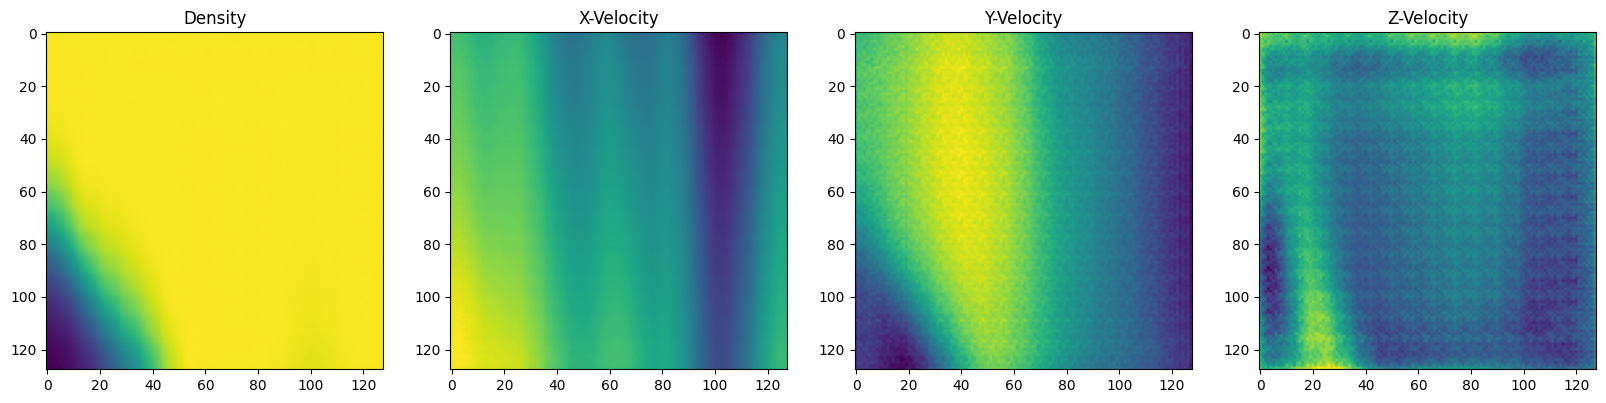

In [ ]:
# Visualize the model predictions on the training set
# make a single plot with 4 subplots for each channel

model.eval()

for idx, (id, batch) in enumerate(test_dataloader):
    inputs = batch
    outputs = model(inputs)
    outputs = outputs.squeeze(0).detach().cpu().numpy()
    inputs = inputs.squeeze(0).detach().cpu().numpy()
    break

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
for i in range(4):
    axs[i].imshow(outputs[i], cmap='viridis')
    axs[i].set_title(titles[i])
plt.show()




In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import os
import pandas as pd
from tqdm import tqdm

def visualize_with_error_maps(inputs, outputs, targets, save_path, idx):
    """
    Create visualization with error maps for training/validation data
    """
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
    metrics = {}
    
    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    for i in range(4):
        # Input visualization
        im = axs[0, i].imshow(inputs[i].cpu().detach().numpy(), cmap='viridis')
        axs[0, i].set_title(f'Input {titles[i]}')
        plt.colorbar(im, ax=axs[0, i])
        
        # Output visualization
        im = axs[1, i].imshow(outputs[i].cpu().detach().numpy(), cmap='viridis')
        axs[1, i].set_title(f'Predicted {titles[i]}')
        plt.colorbar(im, ax=axs[1, i])
        
        # Target visualization
        im = axs[2, i].imshow(targets[i].cpu().detach().numpy(), cmap='viridis')
        axs[2, i].set_title(f'Target {titles[i]}')
        plt.colorbar(im, ax=axs[2, i])
        
        # Error map
        error = outputs[i].cpu().detach().numpy() - targets[i].cpu().detach().numpy()
        im = axs[3, i].imshow(error, cmap='RdBu', norm=plt.Normalize(vmin=-np.abs(error).max(), vmax=np.abs(error).max()))
        axs[3, i].set_title(f'Error Map {titles[i]}')
        plt.colorbar(im, ax=axs[3, i])
        
        # Calculate metrics
        output_i = outputs[i].cpu().detach().numpy()
        target_i = targets[i].cpu().detach().numpy()
        
        # Normalize for PSNR
        output_norm = (output_i - output_i.min()) / (output_i.max() - output_i.min())
        target_norm = (target_i - target_i.min()) / (target_i.max() - target_i.min())
        
        metrics[f'{titles[i]}_mse'] = np.mean((output_i - target_i) ** 2)
        metrics[f'{titles[i]}_ssim'] = ssim(output_i, target_i, data_range=target_i.max() - target_i.min())
        metrics[f'{titles[i]}_psnr'] = psnr(target_norm, output_norm)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}_{idx}.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    return metrics

def visualize_test_output(inputs, outputs, save_path, idx):
    """
    Create visualization for test data showing LR input and HR prediction side by side
    """
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    titles = ['Density', 'X-Velocity', 'Y-Velocity', 'Z-Velocity']
    
    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Plot LR inputs
    for i in range(4):
        im = axs[0, i].imshow(inputs[i], cmap='viridis')
        axs[0, i].set_title(f'LR Input - {titles[i]}')
        plt.colorbar(im, ax=axs[0, i])
        
    # Plot HR predictions
    for i in range(4):
        im = axs[1, i].imshow(outputs[i], cmap='viridis')
        axs[1, i].set_title(f'HR Prediction - {titles[i]}')
        plt.colorbar(im, ax=axs[1, i])
    
    plt.tight_layout()
    plt.savefig(f'{save_path}_{idx}.png', bbox_inches='tight', dpi=300)
    plt.close()

def process_all_data(model, train_dataloader, val_dataloader, test_dataloader, output_dir):
    """
    Process all datasets and generate visualizations and metrics
    """
    model.eval()
    metrics_list = []
    
    # Create output directories
    train_viz_dir = os.path.join(output_dir, 'train_viz')
    val_viz_dir = os.path.join(output_dir, 'val_viz')
    test_viz_dir = os.path.join(output_dir, 'test_viz')
    os.makedirs(train_viz_dir, exist_ok=True)
    os.makedirs(val_viz_dir, exist_ok=True)
    os.makedirs(test_viz_dir, exist_ok=True)
    
    # Process training data
    print("Processing training data...")
    for idx, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        with torch.no_grad():
            outputs = model(inputs)
            metrics = visualize_with_error_maps(
                inputs[0], outputs[0], targets[0],
                os.path.join(train_viz_dir, 'train'), idx
            )
            metrics['dataset'] = 'train'
            metrics['sample_idx'] = idx
            metrics_list.append(metrics)
    
    # Process validation data
    print("Processing validation data...")
    for idx, (inputs, targets) in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            outputs = model(inputs)
            metrics = visualize_with_error_maps(
                inputs[0], outputs[0], targets[0],
                os.path.join(val_viz_dir, 'val'), idx
            )
            metrics['dataset'] = 'validation'
            metrics['sample_idx'] = idx
            metrics_list.append(metrics)
    
    # Process test data
    print("Processing test data...")
    for idx, (id, inputs) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            outputs = model(inputs)
            outputs = outputs.squeeze(0).detach().cpu().numpy()
            visualize_test_output(
                outputs,
                os.path.join(test_viz_dir, 'test'), idx
            )
    
    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(os.path.join(output_dir, 'metrics_summary.csv'), index=False)
    
    # Calculate and save summary statistics
    summary_stats = metrics_df.groupby('dataset').agg(['mean', 'std']).round(4)
    summary_stats.to_csv(os.path.join(output_dir, 'metrics_summary_stats.csv'))
    
    return metrics_df, summary_stats

# Function to print metrics summary
def print_metrics_summary(summary_stats):
    print("\nMetrics Summary:")
    print("=" * 80)
    print(summary_stats)
    print("=" * 80)

In [42]:
output_dir = output_path

# Process all datasets and generate visualizations and metrics
metrics_df, summary_stats = process_all_data(
    model, 
    train_dataloader, 
    val_dataloader, 
    test_dataloader, 
    output_dir
)

# Print summary statistics
print_metrics_summary(summary_stats)

Processing training data...


100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


Processing validation data...


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Processing test data...


100%|██████████| 173/173 [01:43<00:00,  1.68it/s]


Metrics Summary:
           Density_mse         Density_ssim         Density_psnr          \
                  mean     std         mean     std         mean     std   
dataset                                                                    
train           0.0034  0.0065       0.3264  0.3145      16.7076  7.5415   
validation      0.0068     NaN       0.8574     NaN      26.2265     NaN   

           X-Velocity_mse         X-Velocity_ssim          ...  \
                     mean     std            mean     std  ...   
dataset                                                    ...   
train              0.0023  0.0016          0.9018  0.0512  ...   
validation         0.0027     NaN          0.8792     NaN  ...   

           Y-Velocity_psnr         Z-Velocity_mse         Z-Velocity_ssim  \
                      mean     std           mean     std            mean   
dataset                                                                     
train              24.1383  9.9569     